## Performing Spatial Joins in Python
Some great introduction text goes here

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import dask_geopandas
import dask.dataframe as dd
from shapely.geometry import Point

In [2]:
# import coiled
 
# coiled.create_software_environment(
#      account="coiled-examples",
#      name="spatial-join",
#      conda="environment.yml",
# )

## Spatial Join: Geopandas

In [3]:
# read in raw 2009 data (1,000,000 row subset)
df = pd.read_csv(
    "s3://nyc-tlc/trip data/yellow_tripdata_2009-01.csv",
    nrows=1_000_000,
)

In [4]:
# rename columns to standardize schema
df = df.rename(
    columns={
        "vendor_name": "vendor_id",
        "Trip_Pickup_DateTime": "pickup_datetime",
        "Trip_Dropoff_DateTime": "dropoff_datetime",
        "Passenger_Count": "passenger_count",
        "Trip_Distance": "trip_distance",
        "Start_Lon": "pickup_longitude",
        "Start_Lat": "pickup_latitude",
        "Rate_Code": "rate_code",
        "store_and_forward": "store_and_fwd_flag",
        "End_Lon": "dropoff_longitude",
        "End_Lat": "dropoff_latitude",
        "Payment_Type": "payment_type",
        "Fare_Amt": "fare_amount",
        "surcharge": "surcharge",
        "mta_tax": "mta_tax",
        "Tip_Amt": "tip_amount",
        "Tolls_Amt": "tolls_amount",
        "Total_Amt": "total_amount",
    }
)

In [5]:
df.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,VTS,2009-01-04 02:52:00,2009-01-04 03:02:00,1,2.63,-73.991957,40.721567,NaN,NaN,-73.993803,40.695922,CASH,8.9,0.5,NaN,0.00,0.0,9.40
1,VTS,2009-01-04 03:31:00,2009-01-04 03:38:00,3,4.55,-73.982102,40.736290,NaN,NaN,-73.955850,40.768030,Credit,12.1,0.5,NaN,2.00,0.0,14.60
2,VTS,2009-01-03 15:43:00,2009-01-03 15:57:00,5,10.35,-74.002587,40.739748,NaN,NaN,-73.869983,40.770225,Credit,23.7,0.0,NaN,4.74,0.0,28.44
3,DDS,2009-01-01 20:52:58,2009-01-01 21:14:00,1,5.00,-73.974267,40.790955,NaN,NaN,-73.996558,40.731849,CREDIT,14.9,0.5,NaN,3.05,0.0,18.45
4,DDS,2009-01-24 16:18:23,2009-01-24 16:24:56,1,0.40,-74.001580,40.719382,NaN,NaN,-74.008378,40.720350,CASH,3.7,0.0,NaN,0.00,0.0,3.70


In [6]:
# read in neighbourhood polygons
ngbhoods = gpd.read_file(
    '/Users/rpelgrim/Desktop/data/nyc/nyc-communityhealth-shapefiles/CHS_2009_DOHMH_2010B/CHS_2009_DOHMH_2010B.shp',
)[['geometry','FIRST_UHF_', 'UHF_CODE']]
ngbhoods = ngbhoods.to_crs(epsg=4326)

ngbhoods.head(3)

,geometry,FIRST_UHF_,UHF_CODE
0,"POLYGON ((-73.87793 40.90556, -73.87859 40.903...",Kingsbridge - Riverdale,101.0
1,"POLYGON ((-73.85253 40.90985, -73.85235 40.909...",Northeast Bronx,102.0
2,"POLYGON ((-73.85627 40.88315, -73.85666 40.882...",Fordham - Bronx Park,103.0


In [7]:
type(ngbhoods)

geopandas.geodataframe.GeoDataFrame

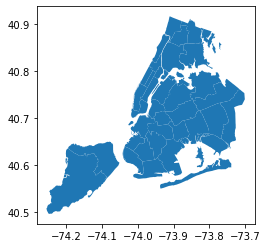

In [8]:
# plot all geometry polygons
ngbhoods.geometry.plot();

In [9]:
# turn taxi_df into geodataframe
taxi_gdf = gpd.GeoDataFrame(
    df, crs="EPSG:4326",
    geometry=[Point(xy) for xy in
              zip(df['pickup_longitude'], df['pickup_latitude'])])

In [10]:
taxi_gdf.tail(3)

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,geometry
999997,CMT,2009-01-12 14:16:57,2009-01-12 14:28:02,1,4.7,-73.984502,40.728968,NaN,NaN,-74.014803,40.708558,Credit,12.9,0.0,NaN,1.93,0.0,14.83,POINT (-73.98450 40.72897)
999998,CMT,2009-01-22 11:21:35,2009-01-22 11:37:06,1,1.5,-73.992235,40.749299,NaN,NaN,-73.982042,40.762873,Cash,9.3,0.0,NaN,0.00,0.0,9.30,POINT (-73.99223 40.74930)
999999,CMT,2009-01-22 08:10:24,2009-01-22 08:39:43,1,5.4,-74.008144,40.723281,NaN,NaN,-74.008787,40.715377,Cash,18.1,0.0,NaN,0.00,0.0,18.10,POINT (-74.00814 40.72328)


In [11]:
# drop lat/long columns
taxi_gdf = taxi_gdf.drop(
    columns= [
        'pickup_longitude', 
        'pickup_latitude', 
        'dropoff_longitude', 
        'dropoff_latitude',
        'vendor_id',
        'rate_code',
        'store_and_fwd_flag',
        'mta_tax',
    ])
taxi_gdf.tail(3)

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,payment_type,fare_amount,surcharge,tip_amount,tolls_amount,total_amount,geometry
999997,2009-01-12 14:16:57,2009-01-12 14:28:02,1,4.7,Credit,12.9,0.0,1.93,0.0,14.83,POINT (-73.98450 40.72897)
999998,2009-01-22 11:21:35,2009-01-22 11:37:06,1,1.5,Cash,9.3,0.0,0.00,0.0,9.30,POINT (-73.99223 40.74930)
999999,2009-01-22 08:10:24,2009-01-22 08:39:43,1,5.4,Cash,18.1,0.0,0.00,0.0,18.10,POINT (-74.00814 40.72328)


Now that both of your datasets have geometry columns you can perform a spatial join.

Perform a left spatial join with taxi_gdf as the left_df and nghboohds as the right_df. Setting the predicate keyword to 'within' will join points in the left_df to polygons from the right_df they are located within:

In [12]:
%%timeit
# perform spatial join
joined = gpd.sjoin(
    taxi_gdf, 
    ngbhoods, 
    how='left',
    predicate="within",
)

1.17 s ± 34.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
# drop index column
joined = joined.drop(columns=['index_right'])

# rename columns
joined.rename(columns={'FIRST_UHF_': 'pickup_ngbhood_name', 'UHF_CODE': 'pickup_ngbhood_id'}, inplace=True)
joined.head(3)

NameError: name 'joined' is not defined

Now that you've performed the spatial join, you can analyse spatial patterns in the data.

For example, you can run a groupby that aggregates the mean trip_distance per pickup neighborhood:

In [ ]:
res = joined.groupby('pickup_ngbhood_name').trip_distance.mean()
res

In [ ]:
res.plot(rot=90);

Clearly, trips started in Southern Queens neighbourhoods are the longest distances.

## Spatial Join: Spatialpandas
Some amazing text goes here...

### Option 1: Read Shapefile into Spatialpandas

In [ ]:
ngbhoods_sp = spatialpandas.from_

### Option 2: Convert GeoPandas into Spatialpandas 

In [16]:
from spatialpandas import GeoDataFrame, GeoSeries

In [17]:
ngbhoods_sp = GeoDataFrame(ngbhoods)
ngbhoods_sp.head(3)

/Users/rpelgrim/mambaforge/envs/dask-dataframe/lib/python3.9/site-packages/spatialpandas/geometry/polygon.py:41: ShapelyDeprecationWarning: Accessing the 'ctypes' attribute is deprecated, and will not be possible any more in Shapely 2.0
  exterior = np.asarray(shape.exterior.ctypes)
/Users/rpelgrim/mambaforge/envs/dask-dataframe/lib/python3.9/site-packages/spatialpandas/geometry/multipolygon.py:42: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in shape:


,geometry,FIRST_UHF_,UHF_CODE
0,"MultiPolygon([[[-73.8779313565267, 40.90556327...",Kingsbridge - Riverdale,101.0
1,"MultiPolygon([[[-73.85252590936993, 40.9098462...",Northeast Bronx,102.0
2,"MultiPolygon([[[-73.85626847312932, 40.8831498...",Fordham - Bronx Park,103.0


In [18]:
type(ngbhoods_sp)

spatialpandas.geodataframe.GeoDataFrame

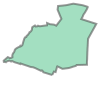

In [19]:
ngbhoods_sp.geometry[2].to_shapely()

### Convert Taxi Data to Spatialpandas Geometry

In [20]:
from spatialpandas.geometry import (
    LineArray,
    MultiLineArray,
    MultiPointArray,
    MultiPolygonArray,
    PointArray,
    PolygonArray,
)

Spatialpandas works slightly differently. It is more flexible and allows you to construct different kinds of geometries.

We'll create Point Arrays from the pickup longitude and latitude columns and then add that PointArray column to our df:

In [21]:
# turn pickup lat/long into spatialpandas geometry
pickups = df[["pickup_longitude", "pickup_latitude"]]
pickup_points = PointArray(pickups)
pickup_points

<PointArray>
[        Point([-73.991957, 40.721567]),
          Point([-73.982102, 40.73629]),
         Point([-74.002587, 40.739748]),
         Point([-73.974267, 40.790955]),
          Point([-74.00158, 40.719382]),
         Point([-73.989806, 40.735006]),
 Point([-73.98404999999998, 40.743544]),
         Point([-73.992635, 40.748362]),
          Point([-73.96969, 40.749244]),
         Point([-73.955173, 40.783044]),
 ...
 Point([-74.00325999999998, 40.727372]),
         Point([-73.988977, 40.726738]),
 Point([-73.98133699999998, 40.742982]),
         Point([-73.993633, 40.751902]),
  Point([-73.95345299999998, 40.78236]),
         Point([-73.997167, 40.737425]),
 Point([-73.96221199999998, 40.779117]),
         Point([-73.873022, 40.774053]),
         Point([-73.984955, 40.756653]),
 Point([-73.98261499999998, 40.782477])]
Length: 10000, dtype: point[float64]

In [22]:
# create GeoDataFrame from PointArray
taxi_gdf_sp = GeoDataFrame(
    {
        "pickup_geo": pickup_points,
    }
)

In [23]:
# drop numeric geo data from df
df2 = df.drop(
    columns=["dropoff_longitude", "dropoff_latitude", "pickup_longitude", "pickup_latitude"],
)

In [24]:
# join dataframes
taxi_gdf_sp = taxi_gdf_sp.merge(
    df2,
    how="left",
    left_index=True,
    right_index=True,
)

/Users/rpelgrim/mambaforge/envs/dask-dataframe/lib/python3.9/site-packages/spatialpandas/geometry/point.py:31: ShapelyDeprecationWarning: Accessing the 'ctypes' attribute is deprecated, and will not be possible any more in Shapely 2.0
  return np.asarray(shape.ctypes)


In [25]:
taxi_gdf_sp.head(3)

,pickup_geo,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,rate_code,store_and_fwd_flag,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,geometry
0,"Point([-73.991957, 40.721567])",VTS,2009-01-04 02:52:00,2009-01-04 03:02:00,1,2.63,NaN,NaN,CASH,8.9,0.5,NaN,0.00,0.0,9.40,"Point([-73.991957, 40.721567])"
1,"Point([-73.982102, 40.73629])",VTS,2009-01-04 03:31:00,2009-01-04 03:38:00,3,4.55,NaN,NaN,Credit,12.1,0.5,NaN,2.00,0.0,14.60,"Point([-73.982102, 40.73629])"
2,"Point([-74.002587, 40.739748])",VTS,2009-01-03 15:43:00,2009-01-03 15:57:00,5,10.35,NaN,NaN,Credit,23.7,0.0,NaN,4.74,0.0,28.44,"Point([-74.002587, 40.739748])"


Now we're ready to perform our spatial join:

In [26]:
from spatialpandas import sjoin

In [27]:
%%time
# execute spatial join
joined_sp = sjoin(
    taxi_gdf_sp, 
    ngbhoods_sp, 
    how='left',
    op='intersects',
)

CPU times: user 3.53 s, sys: 140 ms, total: 3.67 s
Wall time: 3.42 s


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [78]:
joined_sp

,pickup_geo,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,rate_code,store_and_fwd_flag,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,geometry,index_right,FIRST_UHF_,UHF_CODE
0,"Point([-73.991957, 40.721567])",VTS,2009-01-04 02:52:00,2009-01-04 03:02:00,1,2.63,NaN,NaN,CASH,8.9,0.5,NaN,0.00,0.00,9.40,"Point([-73.991957, 40.721567])",29.0,"Union Square, Lower Manhattan",309310.0
1,"Point([-73.982102, 40.73629])",VTS,2009-01-04 03:31:00,2009-01-04 03:38:00,3,4.55,NaN,NaN,Credit,12.1,0.5,NaN,2.00,0.00,14.60,"Point([-73.982102, 40.73629])",27.0,Upper East Side - Gramercy,305307.0
2,"Point([-74.002587, 40.739748])",VTS,2009-01-03 15:43:00,2009-01-03 15:57:00,5,10.35,NaN,NaN,Credit,23.7,0.0,NaN,4.74,0.00,28.44,"Point([-74.002587, 40.739748])",28.0,Chelsea - Village,306308.0
3,"Point([-73.974267, 40.790955])",DDS,2009-01-01 20:52:58,2009-01-01 21:14:00,1,5.00,NaN,NaN,CREDIT,14.9,0.5,NaN,3.05,0.00,18.45,"Point([-73.974267, 40.790955])",18.0,Upper West Side,304.0
4,"Point([-74.00158, 40.719382])",DDS,2009-01-24 16:18:23,2009-01-24 16:24:56,1,0.40,NaN,NaN,CASH,3.7,0.0,NaN,0.00,0.00,3.70,"Point([-74.00158, 40.719382])",28.0,Chelsea - Village,306308.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,"Point([-73.997167, 40.737425])",VTS,2009-01-03 21:33:00,2009-01-03 21:39:00,1,1.10,NaN,NaN,CASH,5.3,0.5,NaN,0.00,0.00,5.80,"Point([-73.997167, 40.737425])",28.0,Chelsea - Village,306308.0
9996,"Point([-73.96221199999998, 40.779117])",VTS,2009-01-03 19:04:00,2009-01-03 19:19:00,5,2.64,NaN,NaN,CASH,10.1,0.0,NaN,0.00,0.00,10.10,"Point([-73.96221199999998, 40.779117])",34.0,None,0.0
9997,"Point([-73.873022, 40.774053])",VTS,2009-01-03 09:54:00,2009-01-03 10:17:00,2,9.06,NaN,NaN,CASH,24.1,0.0,NaN,0.00,4.15,28.25,"Point([-73.873022, 40.774053])",34.0,None,0.0
9998,"Point([-73.984955, 40.756653])",VTS,2009-01-07 19:56:00,2009-01-07 20:04:00,1,3.02,NaN,NaN,Credit,11.3,1.0,NaN,2.00,0.00,14.30,"Point([-73.984955, 40.756653])",28.0,Chelsea - Village,306308.0


In [81]:
joined_sp

,pickup_geo,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,rate_code,store_and_fwd_flag,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,geometry,index_right,FIRST_UHF_,UHF_CODE
0,"Point([-73.991957, 40.721567])",VTS,2009-01-04 02:52:00,2009-01-04 03:02:00,1,2.63,NaN,NaN,CASH,8.9,0.5,NaN,0.00,0.00,9.40,"Point([-73.991957, 40.721567])",29.0,"Union Square, Lower Manhattan",309310.0
1,"Point([-73.982102, 40.73629])",VTS,2009-01-04 03:31:00,2009-01-04 03:38:00,3,4.55,NaN,NaN,Credit,12.1,0.5,NaN,2.00,0.00,14.60,"Point([-73.982102, 40.73629])",27.0,Upper East Side - Gramercy,305307.0
2,"Point([-74.002587, 40.739748])",VTS,2009-01-03 15:43:00,2009-01-03 15:57:00,5,10.35,NaN,NaN,Credit,23.7,0.0,NaN,4.74,0.00,28.44,"Point([-74.002587, 40.739748])",28.0,Chelsea - Village,306308.0
3,"Point([-73.974267, 40.790955])",DDS,2009-01-01 20:52:58,2009-01-01 21:14:00,1,5.00,NaN,NaN,CREDIT,14.9,0.5,NaN,3.05,0.00,18.45,"Point([-73.974267, 40.790955])",18.0,Upper West Side,304.0
4,"Point([-74.00158, 40.719382])",DDS,2009-01-24 16:18:23,2009-01-24 16:24:56,1,0.40,NaN,NaN,CASH,3.7,0.0,NaN,0.00,0.00,3.70,"Point([-74.00158, 40.719382])",28.0,Chelsea - Village,306308.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,"Point([-73.997167, 40.737425])",VTS,2009-01-03 21:33:00,2009-01-03 21:39:00,1,1.10,NaN,NaN,CASH,5.3,0.5,NaN,0.00,0.00,5.80,"Point([-73.997167, 40.737425])",28.0,Chelsea - Village,306308.0
9996,"Point([-73.96221199999998, 40.779117])",VTS,2009-01-03 19:04:00,2009-01-03 19:19:00,5,2.64,NaN,NaN,CASH,10.1,0.0,NaN,0.00,0.00,10.10,"Point([-73.96221199999998, 40.779117])",34.0,None,0.0
9997,"Point([-73.873022, 40.774053])",VTS,2009-01-03 09:54:00,2009-01-03 10:17:00,2,9.06,NaN,NaN,CASH,24.1,0.0,NaN,0.00,4.15,28.25,"Point([-73.873022, 40.774053])",34.0,None,0.0
9998,"Point([-73.984955, 40.756653])",VTS,2009-01-07 19:56:00,2009-01-07 20:04:00,1,3.02,NaN,NaN,Credit,11.3,1.0,NaN,2.00,0.00,14.30,"Point([-73.984955, 40.756653])",28.0,Chelsea - Village,306308.0


Looks like this worked.

Geopandas was faster and required less steps. When working with datasets that are small enough to fit into memory (pandas DataFrames), generally use GeoPandas. Unless you need some of the specific functionality of spatialpandas.

## Spatial Join: at scale with Dask-Geopandas
We're going to be working at scale now with the data for the five-year period from 2009-2013. This data totals ~120GB on disk. We'll need some extra computing power to run this analysis. Let's scale out to a Dask cluster with Coiled:

In [ ]:
# cluster = Cluster(
#     software="coiled-examples/spatial-join",
# )